
<a id='iterative-methods-sparsity'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Métodos Krylov e Condicionamento Matricial

## Conteúdo

- [Métodos Krylov e Condicionamento Matricial](#Métodos-Krylov-e-Condicionamento-Matricial)  
  - [Resumo](#Resumo)  
  - [Matrizes Mal-Condicionadas](#Matrizes-Mal-Condicionadas)  
  - [Algorítimos Interativos Estacionários para Sistemas Lineares](#Algorítimos-Interativos-Estacionários-para-Sistemas-Lineares)  
  - [Métodos de Krylov](#Métodos-de-Krylov)  
  - [Métodos Interativos para Mínimos Quadrados Lineares](#Métodos-Interativos-para-Mínimos-Quadrados-Lineares)  
  - [Métodos Interativos para Autossistemas](#Métodos-Interativos-para-Autossistemas)  
  - [Métodos de Krylov para Cadeias de Markov Dinâmicas](#Métodos-de-Krylov-para-Cadeias-de-Markov-Dinâmicas)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://julia.quantecon.org/) pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob a supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Esta aula pega a estrutura de [métodos numéricos para álgebra linear](https://julia.quantecon.org/numerical_linear_algebra.html) e avança mais no sentido de trabalhar com matrizes grandes e esparsas. No processo, examinaremos a análise numérica fundamental, como matrizes mal condicionadas.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # descomentário para forçar a instalação do pacote

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, Random
Random.seed!(42);  # números aleatórios de sementes para reprodutibilidade

### Aplicações

Nesta seção, consideraremos variações de problemas clássicos

1. Resolvendo um sistema linear para um quadrado de $ A $, onde manteremos o tempo todo, existe uma solução exclusiva para  
  $$
  A x = b
  $$
2. [Solução de mínimos quadrados lineares](https://en.wikipedia.org/wiki/Linear_least_squares), para $ A $ retangular:  
  $$
  \min_x \| Ax -b \|^2
  $$
 Teoricamente, sabemos que se $ A $ tiver colunas linearmente independentes, resultará nas [equações normais](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations):  
  $$
  x = (A'A)^{-1}A'b
  $$
3. No caso de uma matriz quadrada, $ A $, o problema do autovalor de encontrar $ x $ e $ \lambda $ de modo que  
  $$
  A x = \lambda x
  $$
  Para os problemas de autovalor. Lembre-se de que você nem sempre exige todos os $ \lambda $ e, às vezes, o maior (ou menor) seria suficiente. Por exemplo, calcular o raio espectral requer apenas o valor próprio máximo em valor absoluto.  

## Matrizes Mal-Condicionadas

Uma consideração importante na álgebra linear numérica e métodos iterativos em geral é o [número da condição](https://en.wikipedia.org/wiki/Condition_number#Matrices).

Uma matriz mal condicionada é aquela em que a base dos vetores próprios é próxima, mas não exatamente, colinear. Embora isso não cause problemas em papel e caneta, ou com métodos numéricos de precisão infinita, é importante na prática por duas razões

1. Matrizes mal condicionadas introduzem erros numéricos aproximadamente na proporção do log da base 10 do número da condição.
2. A velocidade de convergência de muitos métodos iterativos é baseada nas propriedades espectrais das matrizes (por exemplo, a base formada pelos vetores próprios) e, portanto, sistemas mal condicionados podem convergir lentamente.


As soluções para esses problemas são:

- Tenha cuidado com operações que introduzam erros com base no número da condição (por exemplo, inversões de matriz quando o número da condição é alto);
- Escolha, sempre que possível, representações alternativas que tenham menos colinearidade (por exemplo, uma base polinomial ortogonal em vez de monomial), e
- Use um pré-condicionador para métodos iterativos, que alteram as propriedades espectrais para aumentar a velocidade de convergência.

### Número de condição

Primeiro, vamos definir e explorar o número da condição $ \kappa $:

$$
\kappa(A) \equiv \|A\| \|A^{-1}\|
$$

onde você pode usar a desigualdade de Cauchy – Schwarz para mostrar que $ \kappa (A) \geq 1 $. Embora o número da condição possa ser calculado com qualquer norma, vamos nos concentrar na norma 2.

Primeiro, um aviso sobre os cálculos: calcular o número da condição para uma matriz pode ser uma operação cara (como seria o cálculo de um determinante) e deve ser pensado como aproximadamente equivalente a fazer uma composição automática. Portanto, use-o para o trabalho de detetive criteriosamente.

Vamos olhar para o número de condição de algumas matrizes usando a função `cond` (que permite a escolha da norma, mas mantemos a norma 2 padrão).

In [3]:
A = I(2)
cond(A)

1.0

Aqui vemos um exemplo da matriz melhor condicionada, a matriz de identidade com sua base completamente ortonormal, é 1.

Por outro lado, observe que

In [4]:
ϵ = 1E-6
A = [1.0 0.0
     1.0 ϵ]
cond(A)

2.0000000000005004e6

possui um número de condição da ordem `10E6` - e, portanto, (tomando o log da base 10), seria de esperar introduzir erros numéricos de cerca de 6 dígitos significativos, se você não tomar cuidado. Por exemplo, observe que o inverso possui números negativos extremamente grandes e extremamente pequenos:

In [5]:
inv(A)

2×2 Array{Float64,2}:
  1.0    0.0  
 -1.0e6  1.0e6

Como sabemos que o determinante de matrizes quase colineares é próximo de zero, isso mostra outro sintoma de mau condicionamento.

In [6]:
det(A)

1.0e-6

No entanto, tenha cuidado, pois o determinante possui uma escala, enquanto o número da condição é adimensional. Isto é,

In [7]:
@show det(1000 * A)
@show cond(1000 * A);

det(1000A) = 1.0
cond(1000A) = 2.0000000000005001e6


Nesse caso, o determinante de `A` é 1, enquanto o número de condição estiver intacto. Esse exemplo também permite intuir que o mal-condicionamento de matrizes ocorre quando uma matriz tem escalas radicalmente diferentes (ex.: contem ambos `1` e `1E-6`, ou `1000` e `1E-3`). Isso pode ocorrer frequentemente com aproximação de função e mínimos quadrados lineares.

### Números de condição e operações matriciais

Multiplicar uma matriz por uma constante não altera o número da condição. E as outras operações?

Para este exemplo, vemos que o inverso tem o mesmo número de condição (embora nem sempre seja esse o caso).

In [8]:
@show cond(A)
@show cond(inv(A));

cond(A) = 2.0000000000005004e6
cond(inv(A)) = 2.0000000002463197e6


O número de condição do produto de duas matrizes pode mudar radicalmente e levar as coisas a se tornarem ainda mais mal condicionadas.

Isso ocorre com frequência ao calcular o produto de uma matriz e sua transposição (por exemplo, formar a matriz de covariância). Um exemplo clássico é a [matriz de Läuchli](https://link.springer.com/article/10.1007%2FBF01386022).

In [9]:
lauchli(N, ϵ) = [ones(N)'; ϵ * I(N)]'
ϵ = 1E-8
L = lauchli(3, ϵ) |> Matrix

3×4 Array{Float64,2}:
 1.0  1.0e-8  0.0     0.0   
 1.0  0.0     1.0e-8  0.0   
 1.0  0.0     0.0     1.0e-8

Observe que o número da condição aumenta substancialmente.

In [10]:
@show cond(L)
@show cond(L' * L);

cond(L) = 1.732050807568878e8
cond(L' * L) = 5.345191558726545e32


Você pode mostrar que os autovalores analíticos são $ \{3 + \epsilon ^ 2, \epsilon ^ 2, \epsilon ^ 2 \} $, mas o mau condicionamento significa que é difícil diferenciá-los de $ 0 $.

Isso ocorre ao realizar a [análise dos componentes principais](https://en.wikipedia.org/wiki/Principal_component_analysis#Singular_value_decomposition), que requer cálculos dos valores próprios da matriz de covariância:

In [11]:
sqrt.(eigen(L*L').values) |> sort

DomainError: DomainError with -2.3721342664653315e-17:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

Observe que eles são significativamente diferentes da solução analítica conhecida e, em particular, são difíceis de distinguir de 0.

In [12]:
sqrt.([3 + ϵ^2, ϵ^2, ϵ^2]) |> sort

3-element Array{Float64,1}:
 1.0e-8            
 1.0e-8            
 1.7320508075688772

Como alternativa, poderíamos calculá-los tomando o quadrado dos valores singulares de $ L $, que é muito mais preciso e permite distinguir claramente de zero.

In [13]:
svd(L).S  |> sort

3-element Array{Float64,1}:
 9.999999999999997e-9
 1.0e-8              
 1.7320508075688774  

Da mesma forma, é melhor calcular os mínimos quadrados diretamente, em vez de formar a equação normal (ou seja, $ A 'A x = A' b $):

In [14]:
N = 3
A = lauchli(N, 1E-7)' |> Matrix
b = rand(N+1)
x_sol_1 = A \ b  # using a least-square solver
x_sol_2 = (A' * A) \ (A' * b)  # forming the normal equation ourselves
norm(x_sol_1 - x_sol_2)

2502.05373776057

### Porquê uma base monomial é uma má idéia

Um exemplo clássico de matrizes mal condicionadas é o uso de uma base monomial de um polinômio com interpolação.

Pegue uma grade de pontos, $ x_0,\ ldots x_N $ e valores $ y_0, \ldots y_N $, onde queremos calcular o polinômio interpolador.

Se usarmos a base polinomial mais simples e mais óbvia, o cálculo é calcular os coeficientes $ c_1, \ldots c_n $ em que

$$
P(x) = \sum_{i=0}^N c_i x^i
$$

Para resolver os coeficientes, notamos que este é um sistema simples de equações

$$
\begin{array}
    \,y_0 = c_0 + c_1 x_0 + \ldots c_N x_0^N\\
    \,\ldots\\
    \,y_N = c_0 + c_1 x_N + \ldots c_N x_N^N
\end{array}
$$

Ou, empilhando como matrizes e vetores $ c = \begin {bmatrix} c_0 & \ldots & c_N \end {bmatrix}, y = \begin {bmatrix} y_0 & \ldots & y_N \end {bmatrix} $ e

$$
A = \begin{bmatrix} 1 & x_0 & x_0^2 & \ldots &x_0^N\\
                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                    1 & x_N & x_N^2 & \ldots & x_N^N
    \end{bmatrix}
$$

Podemos então calcular os coeficientes de interpolação como a solução para

$$
A c = y
$$

Implementando isso para a interpolação da função $ exp (x) $:

In [15]:
N = 5
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # gerar alguns dados para interpolação

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

1.356966095045209e-9

A etapa final apenas verifica a interpolação versus a função analítica nos nós. Lembre-se de que isso deve estar muito próximo de zero, pois estamos interpolando a função precisamente nesses nós. Em nosso exemplo, a norma Inf (ou seja, diferença máxima) dos erros de interpolação nos nós é de cerca de 1E-9, o que é razoável para muitos problemas.

Mas observe que, com $ N = 5 $, o número da condição já está na ordem `1E6`.

In [16]:
cond(A)

564652.3214053963

E se aumentarmos o grau do polinômio com a esperança de aumentar a precisão da interpolação?

In [17]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

8.61171429278329e-7

Aqui, vemos que esperar aumentar a precisão entre pontos adicionando termos polinomiais extras é um tiro pela culatra. Indo para um polinômio de 10ª ordem, introduzimos um erro de cerca de `1E-5`, mesmo nos próprios pontos de interpolação.

Isso explode rapidamente.

In [18]:
N = 20
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

19978.410967681375

Para ver a fonte do problema, observe que o número da condição é astronômico.

In [19]:
cond(A)

2.0386741019186427e24

Neste ponto, você deve suspeitar do uso de `inv (A)`, pois consideramos resolver sistemas lineares tomando o inverso como verboten. De fato, isso tornou as coisas muito piores: o erro diminui drasticamente se o resolvermos como um sistêmico linear...

In [20]:
c = A \ y
norm(A * c - f.(x), Inf)

1.864464138634503e-10

Mas um erro de `1E-10` nos próprios nós de interpolação pode ser um problema em muitas aplicações, e se você aumentar `N`, o erro se tornará não trivial eventualmente - mesmo sem tomar o inverso.

O cerne da questão é que a base monomial leva a uma [matriz de Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix), que é especialmente mal condicionada.

#### Além dos fenômenos de Runge

A base monomial também é uma boa oportunidade para analisar um tipo separado de erro devido a [Fenômenos de Runge](https://en.wikipedia.org/wiki/Runge%27s_phenomenon). É uma questão importante na teoria das aproximações, embora não seja motivada por erros numéricos de aproximação.

Acontece que usar uma grade uniforme de pontos é geralmente a pior escolha possível de nós de interpolação para uma aproximação polinomial. Esse fenômeno pode ser visto com a interpolação da função de Runge aparentemente inócua, $ g (x) = \frac {1} {1 + 25 x ^ 2} $.

Vamos calcular a interpolação com uma base monomial para encontrar o $ c_i $ tal que

$$
\frac{1}{1 + 25 x^2} \approx \sum_{i=0}^N c_i x^i,\, \text{ para } -1 \leq x \leq 1
$$

Primeiro, interpolação com $ N = 5 $ e evite tomar o inverso. Nesse caso, desde que evitemos a inversão, os erros numéricos da matriz mal condicionada são administráveis.

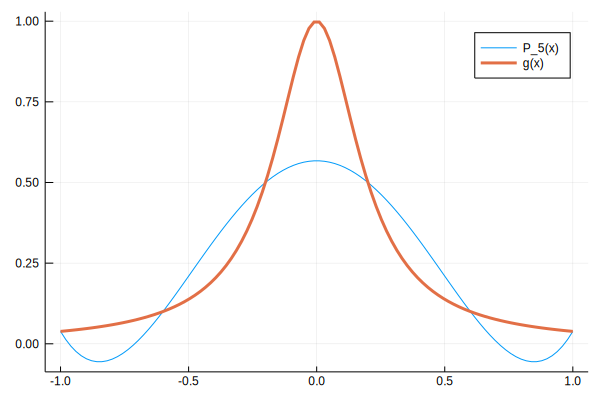

In [21]:
using Plots
N_display = 100
g(x) = 1/(1 + 25x^2)
x_display = range(-1, 1, length = N_display)
y_display = g.(x_display)

# interpolação
N = 5
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_5 = [x_i^n for x_i in x, n in 0:N]
c_5 = A_5 \ y

# use os coeficientes para avaliar na grade x_display
B_5 = [x_i^n for x_i in x_display, n in 0:N]   # calcular monômios para a grade de exibição
y_5 = B_5 * c_5  # calcula para cada um em x_display_grid
plot(x_display, y_5, label = "P_5(x)")
plot!(x_display, y_display, w = 3, label = "g(x)")

Observe que, enquanto a função $ g (x) $ e a aproximação com um polinômio de 5ª ordem, $ P_5 (x) $ coincidem nos 6 nós, a aproximação apresenta muitos erros em qualquer outro lugar.

As oscilações próximas aos limites são as marcas registradas dos fenômenos de Runge. Você pode adivinhar que aumentar o número
pontos de grade e ordem do polinômio levará a melhores aproximações:

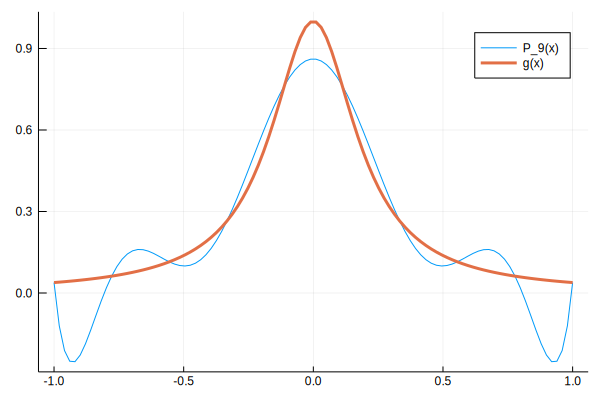

In [22]:
N = 9
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_9 = [x_i^n for x_i in x, n in 0:N]
c_9 = A_9 \ y

# use os coeficientes para avaliar na grade x_display
B_9 = [x_i^n for x_i in x_display, n in 0:N]   # calcular monômios para a grade de exibição
y_9 = B_9 * c_9  # calcula para cada um em x_display_grid
plot(x_display, y_9, label = "P_9(x)")
plot!(x_display, y_display, w = 3, label = "g(x)")

Enquanto a aproximação é melhor perto de `x = 0`, as oscilações próximas aos limites se tornam piores. Adicionar termos polinomiais extras não aumentará globalmente a qualidade da aproximação.

#### Usando uma base polinomial ortogonal

Podemos minimizar os problemas numéricos de uma matriz de base mal condicionada escolhendo uma base diferente para os polinômios.

Por exemplo, os [polinômios de Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_polynomials) formam uma base ortonormal sob um produto interno apropriado, e podemos formar aproximações precisas de alta ordem, com muito pouco erro numérico:

norm(g_approx.(x) - g.(x), Inf) = 4.440892098500626e-16


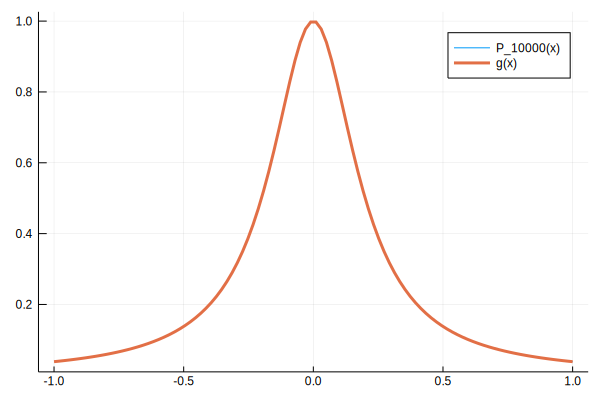

In [23]:
using ApproxFun
N = 10000
S = Chebyshev(-1.0..1.0)  # formar a base de chebyschev
x = points(S, N)  # escolher os nós de chebyschev
y = g.(x)
g_approx = Fun(S,ApproxFun.transform(S,y))  # transformar se encaixa no polinômio
@show norm(g_approx.(x) - g.(x), Inf)
plot(x_display, g_approx.(x_display), label = "P_10000(x)")
plot!(x_display, g.(x_display), w = 3, label = "g(x)")

Além do uso de uma base polinomial diferente, estamos nos aproximando de diferentes nós (ou seja, os [nós de Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_nodes)). A interpolação com polinômios de Chebyshev nos nós de Chebyshev acaba minimizando (mas não eliminando) os fenômenos de Runge.

#### Lições para aproximação e interpolação

Resumir

1. Verifique o número da condição nos sistemas que você suspeita estarem mal condicionados (com base na intuição de colinearidade);
2. Se você estiver trabalhando com matrizes mal condicionadas, tenha cuidado especial para não tomar inversa ou multiplicar pela transposição;
3. Evite uma base polinomial monomial. Em vez disso, use polinômios (por exemplo, Chebyshev ou Lagrange) ortogonais sob um produto interno apropriado ou use uma base não global, como splines cúbicos, e
4. Se possível, evite usar uma grade uniforme para interpolação e aproximação e escolha os nós apropriados para a base.


No entanto, às vezes você não pode evitar matrizes mal condicionadas. Isso é especialmente comum na discretização de PDEs e com mínimos lineares.

## Algorítimos Interativos Estacionários para Sistemas Lineares

Como antes, considere resolver a equação

$$
A x = b
$$

Agora, focaremos nos casos em que $ A $ é maciço (por exemplo, potencialmente milhões de equações), esparso e às vezes mal condicionado - mas sempre existe uma solução única.

Embora isso possa parecer excessivo, ocorre na prática devido à maldição da dimensionalidade, discretizações de PDEs e ao trabalhar com big data.

Os métodos das aulas anteriores (por exemplo, fatoração e abordagens semelhantes à eliminação gaussiana) são chamados de métodos diretos e, em teoria, são capazes de convergir para a solução exata em um número finito de etapas enquanto trabalha diretamente com a matriz na memória.

Em vez disso, as soluções iterativas começam com um palpite sobre uma solução e iteram até a convergência. O benefício será que cada iteração use uma operação de ordem inferior (por exemplo, um produto vetor de matriz $ O (N ^ 2) $) que tornará possível:

1. Resolver sistemas muito maiores, mesmo que feitos com menos precisão.
2. Definir operadores lineares em termos de produtos vetoriais matriciais, em vez de armazenar como matriz.
3. Obtenha soluções aproximadas em andamento antes da conclusão de todas as etapas do algoritmo, diferentemente dos métodos diretos que fornecem apenas uma solução no final.


Obviamente, não há almoço grátis e a ordem computacional das iterações seria comparável aos métodos diretos para um determinado nível de tolerância (por exemplo, operações de $ O (N ^ 3) $ podem ser necessárias para resolver um sistema não estruturado denso).

Existem dois tipos de métodos iterativos que consideraremos: primeiro são métodos estacionários que iteram em um mapa de maneira semelhante a problemas de pontos fixos e o segundo são os [Métodos de Kyrlov](https://en.wikipedia.org/wiki/Krylov_subspace ), que iterativamente resolvem usando multiplicações à esquerda do operador linear.

Para nossos exemplos principais, usaremos a avaliação da Cadeia de tempo contínuo markov da [métodos numéricos para álgebra linear](https://julia.quantecon.org/numerical_linear_algebra.html). Ou seja, dado um vetor de pagamento $ r $, uma taxa de desconto $ \rho $ e o gerador infinitesimal da cadeia de markov $ Q $, resolva a equação

$$
\rho v = r + Q v
$$

Com os tamanhos e tipos de matrizes aqui, os métodos iterativos são inadequados na prática, mas nos ajudarão a entender
as características da convergência e como elas se relacionam com o condicionamento matricial.

### Métodos estacionários

Primeiro, resolveremos com métodos diretos, que fornecerão a solução para a precisão da máquina.

In [24]:
using LinearAlgebra, IterativeSolvers, Statistics
α = 0.1
N = 100
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q
v_direct = A \ r
mean(v_direct)

100.00000000000004

Sem prova, considere a taxa de desconto de $ \rho> 0 $; este problema pode ser configurado como uma contração para resolver a equação de Bellman através de métodos como iteração de função de valor.

A condição que examinaremos aqui é chamada [**dominância diagonal**](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix).

$$
|A_{ii}| \geq \sum_{j\neq i} |A_{ij}| \quad\text{for all } i = 1\ldots N
$$

Ou seja, para cada linha, a diagonal é ligeiramente maior em valor absoluto do que a soma de todos os outros elementos na linha. Em casos onde é estritamente maior, dizemos que a matriz é estritamente diagonalmente dominante.

No nosso exemplo, dado que $ Q $ é o gerador infinitesimal de uma cadeia de markov, sabemos que cada linha é igual a 0 e, portanto, é fracamente diagonalmente dominante.

No entanto, observe que quando $ \rho> 0 $, como a diagonal de $ Q $ é negativa, $ A = ρ I - Q $ torna a matriz estritamente dominante na diagonal.

### Iteração de Jacobi 

Para matrizes **estritamente diagonais**, você pode provar que um procedimento simples de decomposição e iteração convergirá.

Para resolver um sistema $ A x = b $, divida a matriz $ A $ em sua diagonal e fora da diagonal. Isso é,

$$
A = D + R
$$

onde

$$
D = \begin{bmatrix} A_{11} & 0 & \ldots & 0\\
                    0    & A_{22} & \ldots & 0\\
                    \vdots & \vdots & \vdots & \vdots\\
                    0 & 0 &  \ldots & A_{NN}
    \end{bmatrix}
$$

e

$$
R = \begin{bmatrix} 0 & A_{12}  & \ldots & A_{1N} \\
                    A_{21}    & 0 & \ldots & A_{2N} \\
                    \vdots & \vdots & \vdots & \vdots\\
                    A_{N1}  & A_{N2}  &  \ldots & 0
    \end{bmatrix}
$$

Rearranjando $ (D + R)x = b $ como

$$
\begin{align}
D x &= b - R x\\
x &= D^{-1} (b - R x)
\end{align}
$$

Onde, como $ D $ é diagonal, seu inverso é trivial para calcular com complexidade de $ O (N) $.

Para resolver, faça uma iteração $ x ^ k $, começando em $ x ^ 0 $ e, em seguida, forme um novo palpite com

$$
x^{k+1} = D^{-1}(b - R x^k)
$$

A complexidade aqui é um $ O (N ^ 2) $ para o produto vetor de matriz e um $ O (N) $ para a subtração e divisão do vetor.

O pacote [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl) implementa esse método.

Para o nosso exemplo, começamos se adivinhar e resolver a função value e iterar

In [25]:
using IterativeSolvers, LinearAlgebra, SparseArrays
v = zeros(N)
jacobi!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf)

norm(v - v_direct, Inf) = 0.022858373200932647


0.022858373200932647

Com isso, após 40 iterações, você vê o erro na ordem de `1E-2`.

### Outros métodos estacionários

Na prática, existem muitos métodos melhores que a iteração Jacobi, por exemplo [Gauss-Siedel](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method). que divide a matriz $ A = L + U $ em uma matriz triangular inferior $ L $ e em uma triangular superior $ U $ sem a diagonal.

A iteração se torna

$$
L x^{k+1} = b - U x^k
$$

Nesse caso, como a matriz $ L $ é triangular, o sistema pode ser resolvido em operações $ O (N ^ 2) $ após a formação de $ b - U x ^ k $:

In [26]:
v = zeros(N)
gauss_seidel!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 1.5616376089155892e-5


A precisão aumenta substancialmente, após 40 iterações, você vê o erro na ordem de `1E-5`

Outro exemplo é [SOR](https://en.wikipedia.org/wiki/Successive_over-relaxation), que pega um parâmetro de relaxamento $ \omega> 1 $ e decompõe a matriz como $ A = L + D + U $ com $ L, U $ são estritamente matrizes diagonais superiores e inferiores, e $ D $ é uma diagonal.

Decomponha a matriz $ A $, multiplique o sistema por $ \omega $ e reorganize para encontrar

$$
(D + \omega L) x^{k+1} = \omega b - \left(\omega U +(\omega - 1)D \right)x^k
$$

Nesse caso, $ D + \omega L $ é uma matriz triangular e, portanto, a resolução linear é de $ O (N ^ 2) $.

In [27]:
v = zeros(N)
sor!(v, A, r, 1.1, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 3.745356593753968e-7


A precisão é agora `1E-7`. Se você alterar o parâmetro para $ \omega = 1,2 $, a precisão aumentará ainda mais para `1E-9`.

Essa técnica é comum em métodos iterativos: a adição frequente de um parâmetro de amortecimento ou relaxamento acelerará de maneira contra-intuitiva o processo de convergência.

**Nota:** os métodos iterativos estacionários nem sempre são usados diretamente, mas às vezes são usados como uma etapa de "suavização" (por exemplo, executando 5 a 10 vezes) antes de usar outros métodos de Krylov.

## Métodos de Krylov 

Um conjunto de métodos iterativos mais comumente usado é baseado em [subespaços de Krylov](https://en.wikipedia.org/wiki/Krylov_subspace) que envolvem a iteração do produto vetor de matriz $ A ^ kx $ e ortogonalizam para garantir a resultante a iteração não é muito colinear.

O método protótipo de Krylov é o [Gradiente Conjugado](https://en.wikipedia.org/wiki/Conjugate_gradient_method), que requer que a matriz $ A $ seja simétrica e positiva definida.

Resolvendo um exemplo

In [28]:
N = 100
A = sprand(100, 100, 0.1)   # 10 porcento de não-nulos
A = A * A'  # jeito fácil de se gerar uma matriz positiva semidefinida
@show isposdef(A)
b = rand(N)
x_direct = A \ b  # solucionador direto esparso mais apropriado daqui
cond(Matrix(A * A'))

isposdef(A) = true


6.770830820514324e11

Observe que os números de condição tendem a ser grandes para matrizes grandes e aleatórias.

Resolvendo este sistema com o método do gradiente conjugado:

In [29]:
x = zeros(N)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 183 iterations.

### Introdução ao précondicionamento

Se você disser a um analista numérico que está usando métodos diretos, a primeira pergunta deles pode ser "qual fatoração?" - mas se você lhes disser que está usando um método iterativo, eles podem perguntar "qual o pré-condicionador?".

Conforme discutido no início da aula, as propriedades espectrais das matrizes determinam a taxa de convergência das matrizes iterativas. Em particular, matrizes mal condicionadas podem convergir lentamente com métodos iterativos pelas mesmas razões que a iteração ingênua da função de valor convergirá lentamente se a taxa de desconto estiver próxima de '1'.

O pré-condicionamento resolve esse problema ajustando as propriedades espectrais da matriz, ao custo de algumas operações computacionais extras.


Para ver um exemplo de um pré-condicionador correto, considere uma matriz $ P $ que possui uma inversa conveniente e numericamente estável. Então,

$$
\begin{align}
A x &= b\\
A P^{-1} P x &= b\\
A P^{-1} y &= b\\
P x &= y
\end{align}
$$

Ou seja, resolva $ (A P ^ {- 1}) y = b $ por $ y $ e depois resolva $ P x = y $ por $ x $.

Existem todos os tipos de pré-condicionadores específicos para cada problema, os principais recursos são que eles têm maneiras convenientes (e de ordem inferior!) De resolver o sistema resultante e diminuir o número de condições da matriz. Para ver isso em ação, podemos olhar para um pré-condicionador simples.

A pré-condição diagonal é simplesmente `P = Diagonal (A)`. Dependendo da matriz, isso pode alterar um pouco ou muito o número da condição.

In [30]:
AP = A * inv(Diagonal(A))
@show cond(Matrix(A))
@show cond(Matrix(AP));

cond(Matrix(A)) = 822850.5999924907
cond(Matrix(AP)) = 627706.2622058549


Mas pode ou não diminuir o número de iterações:

In [31]:
using Preconditioners
x = zeros(N)
P = DiagonalPreconditioner(A)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 183 iterations.

Outro pré-condicionador clássico é a decomposição de LU incompleta:

In [32]:
using IncompleteLU
x = zeros(N)
P = ilu(A, τ = 0.1)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 96 iterations.

O parâmetro `τ` determina o grau de decomposição da LU a ser conduzida, fornecendo uma compensação entre o pré-condicionador e a velocidade de resolução.

Uma boa regra geral é que você quase sempre deve usar um pré-condicionador com métodos iterativos e deve tentar encontrar os adequados para o seu problema.

Por fim, a tentativa ingênua de se fazer outra abordagem de pré-condicionamento (chamada de [Multigrid Algébrico](https://en.wikipedia.org/wiki/Multigrid_method#Algebraic_MultiGrid_%28AMG%29)) nos dá uma queda adicional no número de iterações.

In [33]:
x = zeros(N)
P = AMGPreconditioner{RugeStuben}(A)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 60 iterations.

*Nota:* O pré-condicionamento também está disponível para métodos estacionários e iterativos (consulte [este exemplo](https://en.wikipedia.org/wiki/Preconditioner#Preconditioned_iterative_methods)), mas
freqüentemente não é implementado, pois não é frequentemente usado para a solução completa.

### Métodos para matrizes em geral

Existem muitos algoritmos que exploram a estrutura da matriz (por exemplo, o método do gradiente conjugado para definido positivo e MINRES para matrizes que são apenas simétricas).

Por outro lado, se você não possui nenhuma estrutura para sua matriz esparsa, o GMRES é uma boa abordagem.

Para experimentar esses métodos, usaremos nosso problema de interpolação mal condicionado com uma base monomial.

In [34]:
using IterativeSolvers

N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # gerar alguns dados para interpolação
A = sparse([x_i^n for x_i in x, n in 0:N])
c = zeros(N+1)  # palpite inicial requerido para soluções interativas
results = gmres!(c, A, y, log=true, maxiter = 1000)
println("cond(A) = $(cond(Matrix(A))), $(results[end]) Norm error $(norm(A*c - y, Inf))")

cond(A) = 4.462833495403007e12, Converged after 11 iterations. Norm error 7.62520357966423e-8


Esse método convergiu em 11 iterações. Agora tente com um pré-condicionador de LU incompleto, vemos que ele converge imediatamente.

In [35]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # gerar alguns dados para interpolação
A = [x_i^n for x_i in x, n in 0:N]
P = ilu(sparse(A), τ = 0.1)
c = zeros(N+1)  # palpite inicial requerido para soluções interativas
results = gmres!(c, A, y, Pl = P,log=true, maxiter = 1000)
println("$(results[end]) Norm error $(norm(A*c - y, Inf))")

Converged after 1 iterations. Norm error 4.5034175855107605e-7


Enquanto outros pré-condicionadores (por exemplo, `DiagonalPreconditioner`) podem salvar apenas uma ou duas iterações. Lembre-se, no entanto, de considerar o custo do processo de pré-condicionamento no seu problema...

### Métodos de matrizes livres

Primeiro, vamos usar um método de Krylov para resolver nosso simples problema de avaliação:

In [36]:
α = 0.1
N = 100
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q
v = zeros(N)
results = gmres!(v, A, r, log=true)
v_sol = results[1]
println("$(results[end])")

Converged after 20 iterations.


Enquanto a matriz `A` era importante para ser mantida na memória para métodos diretos, métodos de Krylov, como GMRES, são construídos em produtos vetoriais de matriz, ou seja, $ A x $ para iterações nos $ x $.

Este produto pode ser gravado diretamente por um determinado $ x $,

$$
A x = \begin{bmatrix} (\rho + \alpha) x_1 - \alpha x_2\\
                    - \alpha x_1 + (\rho + 2 \alpha) x_2 - \alpha x_3\\
                    \vdots\\
                    - \alpha x_{N-2} + (\rho + 2 \alpha) x_{N-1} - \alpha x_{N}\\
                    - \alpha x_{N-1} + (\rho + \alpha) x_N
    \end{bmatrix}
$$

Isso pode ser implementado como uma função (no local ou fora do local) que calcula $ y = A x $.

In [37]:
A_mul(x) = [ (ρ + α) * x[1] - α * x[2];
             [-α * x[i-1] + (ρ + 2*α) * x[i] - α * x[i+1] for i in 2:N-1];  # compreensão
             - α * x[end-1] + (ρ + α) * x[end]]

x = rand(N)
@show norm(A * x - A_mul(x))  # comprarar à matriz;

norm(A * x - A_mul(x)) = 0.0


A linha final verifica se a função `A_mul` fornece o mesmo resultado que a multiplicação da matriz com o` A` original para um vetor aleatório.

Em matemática abstrata, um [operador linear de dimensão finita](https://en.wikipedia.org/wiki/Linear_map) é um mapeamento de $ A: R ^ N \ para R ^ N $ cumprindo vários critérios, como $ A (c_1 x_1 + c_2 x_2) = c_1 A x_1 + c_2 A x_2 $ para escalares $ c_i $ e vetores $ x_i $.

Passando da matemática abstrata para a [programação genérica](https://julia.quantecon.org/../more_julia/generic_programming.html), podemos pensar em um operador linear como um mapa que atende a vários requisitos (por exemplo, multiplicar à esquerda para aplicar o mapa `*`, um multiplicador à esquerda no local `mul!`, um tamanho `associado`, etc.). Uma matriz Julia é apenas uma implementação possível do conceito abstrato de operador linear.

Os invólucros de conveniência podem fornecer parte do padrão que transforma a função `A_mul` em algo que se comporta como uma matriz. 1
O pacote é [LinearMaps.jl](https://github.com/Jutho/LinearMaps.jl) e outro é [LinearOperators.jl](https://github.com/JuliaSmoothOptimizers/LinearOperators.jl)

In [38]:
using LinearMaps
A_map = LinearMap(A_mul, N)  # o mapa usa a função A_mul

LinearMaps.FunctionMap{Float64}(A_mul, 100, 100; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

Agora, com o objeto `A_map`, podemos realizar muitas das operações que esperamos de uma matriz.

In [39]:
x = rand(N)
@show norm(A_map * x  - A * x)
y = similar(x)
mul!(y, A_map, x) # multiplicação no local
@show norm(y - A * x)
@show size(A_map)
@show norm(Matrix(A_map) - A)
@show nnz(sparse(A_map));

norm(A_map * x - A * x) = 0.0
norm(y - A * x) = 0.0
size(A_map) = (100, 100)
norm(Matrix(A_map) - A) = 0.0
nnz(sparse(A_map)) = 298


**Nota:** No caso de `sparse (A_map)` e `Matrix (A_map)`, o código está usando o operador de multiplicação esquerdo com vetores de base padrão `N` para construir a matriz completa. Isso deve ser usado apenas para fins de teste.

Mas observe que, como o operador linear não possui operações de indexação, não é uma matriz.

In [40]:
typeof(A_map) <: AbstractArray

false

Desde que os algoritmos que usam operadores lineares sejam escritos genericamente (por exemplo, usando as funções vetor-matriz `*` ou `mul!`, Etc.) e os tipos de funções não sejam desnecessariamente restringidos para serem `Matrix` ou` AbstractArray` quando não é estritamente necessário, o tipo `A_map` pode funcionar em locais que exigiriam uma matriz.

Por exemplo, os métodos de Krylov em `IterativeSolvers.jl` são escritos para multiplicação à esquerda, genericamente:

In [41]:
results = gmres(A_map, r, log = true)  # Método de Krylov usando o tipo sem matriz
println("$(results[end])")

Converged after 20 iterations.


Esses métodos geralmente não são competitivos com métodos diretos esparsos, a menos que os problemas se tornem muito grandes. Nesse caso, você frequentemente desejará trabalhar com vetores pré-alocados. Em vez de usar `y = A * x` para produtos vetoriais matriciais, você usaria a função` mul! (Y, A, x) `no local. Todos os wrappers para operadores lineares suportam versões não alocadas no local para essa finalidade.

In [42]:
function A_mul!(y, x)  # versão no local
    y[1] = (ρ + α) * x[1] - α * x[2]
    for i in 2:N-1
        y[i] = -α * x[i-1] + (ρ + 2α) * x[i] -α * x[i+1]
    end
    y[end] = - α * x[end-1] + (ρ + α) * x[end]
    return y
end
A_map_2 = LinearMap(A_mul!, N, ismutating = true)  # ismutating == in-loco

v = zeros(N)
@show norm(A_map_2 * v - A * v)  # ainda pode ligar com * e alocar
results = gmres!(v, A_map_2, r, log=true)  # gmres in-loco
println("$(results[end])")

norm(A_map_2 * v - A * v) = 0.0
Converged after 20 iterations.


Por fim, lembre-se de que os operadores lineares podem compor, de modo que $ A (c_1 x) + B (c_2 x) + x = (c_1 A + c_2 B + I) x $ seja bem definido para qualquer operador linear - apenas Como
seria para matrizes $ A, B $ e escalares $ c_1, c_2 $.

Por exemplo, considere $ 2 A x + x = (2 A + I) x \equiv B x $ como um novo mapa linear,

In [43]:
B = 2.0 * A_map  + I  # operador linear composto
B * rand(N)  # multiplicar à esquerda funciona com a composição
typeof(B)

LinearMaps.LinearCombination{Float64,Tuple{LinearMaps.CompositeMap{Float64,Tuple{LinearMaps.FunctionMap{Float64,typeof(A_mul),Nothing},LinearMaps.UniformScalingMap{Float64}}},LinearMaps.UniformScalingMap{Bool}}}

Os invólucros, como os invólucros `LinearMap`, possibilitam essa composição mantendo o gráfico de composição da expressão (ou seja,` LinearCombination`) e implementando a multiplicação à esquerda recursivamente usando as regras de linearidade.

Outro exemplo é resolver a equação $ \rho v = r + Q v $ para $ v $ com a composição de métodos sem matriz por $ L $, em vez de criar o operador $ A = \rho - Q $ completo, que nós implementado como `A_mul`

In [44]:
Q_mul(x) = [ -α * x[1] +     α * x[2];
            [α * x[i-1] - 2*α * x[i] + α*x[i+1] for i in 2:N-1];  # comprehension
            α * x[end-1] - α * x[end];]
Q_map = LinearMap(Q_mul, N)
A_composed = ρ * I - Q_map   # map composition, performs no calculations
@show norm(A - sparse(A_composed))  # test produces the same matrix
gmres(A_composed, r, log=true)[2]

norm(A - sparse(A_composed)) = 0.0


Converged after 20 iterations.

Neste exemplo, a multiplicação à esquerda do `A_composed` usado por` gmres` usa a multiplicação à esquerda do `Q_map` e` I` com as regras de linearidade. A operação `A_composed = ρ * I - Q_map` simplesmente cria o tipo` LinearMaps.LinearCombination` e não realiza cálculos por si só.

## Métodos Interativos para Mínimos Quadrados Lineares

Em teoria, a solução para o problema dos mínimos quadrados, $ \min_x \ | Ax -b \ | ^ 2 $ é simplesmente a solução para as equações normais $ (A'A) x = A'b $.

Vimos, no entanto, que na prática os métodos diretos usam uma decomposição QR - em parte porque $ A $ mal condicionados se tornam ainda piores quando $ A 'A $ é formado.

Para grandes problemas, também podemos considerar os métodos de Krylov para resolver o problema dos mínimos quadrados lineares. Uma formulação é o algoritmo [LSMR](https://stanford.edu/group/SOL/software/lsmr/LSMR-SISC-2011.pdf) que pode resolver os problemas regularizados

$$
\min_x \| Ax -b \|^2 + \| \lambda x\|^2
$$

O objetivo do parâmetro $ \lambda \geq 0 $ é amortecer o processo de iteração e / ou regularizar a solução. Isso não é necessário, mas pode ajudar na convergência para matrizes $ A $ mal condicionadas. Com o
parâmetro de amortecimento, as equações normalizadas se tornariam $ (A'A + \lambda ^ 2 I) x = A'b $.

Podemos comparar a solução do problema dos mínimos quadrados com LSMR e métodos diretos

In [45]:
M = 1000
N = 10000
σ = 0.1
β = rand(M)
# simular dados
X = sprand(N, M, 0.1)
y = X * β + σ * randn(N)
β_direct = X \ y
results = lsmr(X, y, log = true)
β_lsmr = results[1]
@show norm(β_direct - β_lsmr)
println("$(results[end])")

norm(β_direct - β_lsmr) = 8.02458149081313e-6
Converged after 15 iterations.


Observe que, em vez de formar esta versão das equações normais, o algoritmo LSMR usa os $ A x $ e $ A 'y $ (ou seja, o produto vetor de matriz e o produto vetorial de transposição de matriz) para implementar uma solução iterativa. Diferentemente das versões anteriores, a multiplicação à esquerda é insuficiente, pois os mínimos quadrados também tratam da transposição dos operadores. Por esse motivo, para usar métodos sem matriz, é necessário definir as funções `A * x` e` transpose (A) * y` separadamente.

In [46]:
# Pode implementar como funções sem matriz.
X_func(u) = X * u  # prpduto-vetor da matriz
X_T_func(v) = X' * v  # ou seja, produto de vetor adjacente

X_map = LinearMap(X_func, X_T_func, N, M)
results = lsmr(X_map, y, log = true)
println("$(results[end])")

Converged after 15 iterations.


## Métodos Interativos para Autossistemas

Quando você usa `eigen` em uma matriz densa, ele calcula uma composição própria e fornece todos os valores próprios e vetores próprios.

Embora algumas vezes isso seja necessário, uma decomposição espectral de uma matriz densa e não estruturada é uma das operações mais caras de $ O (N ^ 3) $ (ou seja, possui uma das maiores constantes). Para matrizes grandes, geralmente é inviável.

Felizmente, você frequentemente precisa apenas de alguns ou até de um único vetor próprio / valor próprio, o que permite um conjunto diferente de algoritmos.

Por exemplo, no caso de uma cadeia de markov no tempo discreto, para encontrar a distribuição estacionária, estamos procurando o vetor próprio associado ao valor próprio 1. Como de costume, um pouco de álgebra linear percorre um longo caminho.

No [teorema de Perron-Frobenius](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem#Stochastic_matrices), o maior valor próprio de uma matriz estocástica irredutível é 1 - o mesmo valor próprio que procuramos .

Os métodos iterativos para resolver sistemas autônomos permitem atingir a menor magnitude, maior magnitude e muitos outros. A biblioteca mais fácil de usar é [Arpack.jl](https://julialinearalgebra.github.io/Arpack.jl/latest/).

Como um exemplo,

In [47]:
using Arpack, LinearAlgebra
N = 1000
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
A_adjoint = A'

λ, ϕ = eigs(A_adjoint, nev=1, which=:LM, maxiter=1000)  # Find 1 of the largest magnitude eigenvalue
ϕ = real(ϕ) ./ sum(real(ϕ))
@show λ
@show mean(ϕ);

λ = Complex{Float64}[1.0000000000000189 + 0.0im]
mean(ϕ) = 0.0010000000000000002


De fato, o `λ` é igual a` 1`. Se você escolher `nev = 2`, isso forneceria aos pares próprios os dois maiores valores próprios em magnitude absoluta.

*Dica*: se você receber erros ao usar o `Arpack`, aumente o parâmetro` maxiter` para seus problemas.

Os métodos iterativos para sistemas autônomos baseiam-se em produtos vetoriais de matriz em vez de decomposições e são passíveis de abordagens sem matriz. Por exemplo, pegue a cadeia de Markov para um processo simples de contagem

1. A contagem começa em $ 1 $ e tem um máximo de $ N $.
2. Com probabilidade $ \theta \geq 0 $ e uma contagem existente é perdida com a probabilidade $ \zeta \geq 0 $, de modo que $ \theta + \zeta \leq 1 $.
3. Se a contagem for de $ 1 $, a única transição será adicionar uma contagem com probabilidade $ \theta $
4. Se a contagem atual for $ N $, a única transição é perder a contagem com probabilidade $ \zeta $


Primeiro, localize a matriz de transição $ P $ e sua adjacente diretamente como um cheque:

In [48]:
θ = 0.1
ζ = 0.05
N = 5
P = Tridiagonal(fill(ζ, N-1), [1-θ; fill(1-θ-ζ, N-2); 1-ζ], fill(θ, N-1))
P'

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.9  0.05   ⋅     ⋅     ⋅  
 0.1  0.85  0.05   ⋅     ⋅  
  ⋅   0.1   0.85  0.05   ⋅  
  ⋅    ⋅    0.1   0.85  0.05
  ⋅    ⋅     ⋅    0.1   0.95

Implementando o produto de vetor adjacente diretamente e verificando se ele fornece a mesma matriz que o acessório:

In [49]:
P_adj_mul(x) = [ (1-θ) * x[1] + ζ * x[2];
                [θ * x[i-1] + (1-θ-ζ) * x[i] + ζ * x[i+1] for i in 2:N-1];  # compreensão
            θ * x[end-1] + (1-ζ) * x[end];]
P_adj_map = LinearMap(P_adj_mul, N)
@show norm(P' - sparse(P_adj_map))

norm(P' - sparse(P_adj_map)) = 0.0


0.0

Finalmente, resolvendo a distribuição estacionária usando o método sem matriz (que pode ser verificado com a abordagem de decomposição de $ P '$):

In [50]:
λ, ϕ = eigs(P_adj_map, nev=1, which=:LM, maxiter=1000)
ϕ = real(ϕ) ./ sum(real(ϕ))
@show λ
@show ϕ

λ = Complex{Float64}[1.0 + 0.0im]
ϕ = [0.03225806451612657; 0.06451612903225695; 0.1290322580645172; 0.25806451612903425; 0.516129032258065]


5×1 Array{Float64,2}:
 0.03225806451612657
 0.06451612903225695
 0.1290322580645172 
 0.25806451612903425
 0.516129032258065  

É claro que, para esse simples problema, a composição direta de produtos será significativamente mais rápida. Use apenas métodos iterativos sem matriz para sistemas grandes nos quais você não precisa de todos os valores próprios.

## Métodos de Krylov para Cadeias de Markov Dinâmicas

Este exemplo aplica os métodos nesta aula a uma grande cadeia de Markov de tempo contínuo e fornece alguma prática para trabalhar com matrizes de dimensões arbitrárias.

Considere uma versão da dinâmica da cadeia de Markov em [Per19](https://julia.quantecon.org/../zreferences.html#perla2019), em que uma empresa possui um número discreto de clientes de diferentes tipos. Para manter as coisas o mais simples possível, suponha que haja $ m = 1, \ldots M $ tipos de consumidores e que a empresa possa ter $ n = 1, \ldots N $ consumidores de cada tipo.

Para definir a notação, seja $ n_m \in \{1, \ldots N \} $ o número de consumidores do tipo $ m $, para que o estado de uma empresa seja $ \{n_1, \ldots n_m \ldots, n_M \} $. A cardinalidade dos estados possíveis é então $ \mathbf {N} \equiv N ^ M $, que pode explodir rapidamente à medida que o número de tipos aumenta.

O processo estocástico é um processo simples de contar / esquecer, como a seguir.

1. Para cada $ 1 \leq n_m (t) <N $, há uma intensidade de $ \theta $ de um novo cliente aumentando $ n_m (t + \Delta) = n_m (t) + 1 $
2. Para cada $ 1 <n_m (t) \leq N $, há uma intensidade de $ \zeta $ de perda de um cliente, de modo que $ n_m (t + \Delta) = n_m (t) - 1 $

### Gerador livre de matriz infinitesimal

Para definir uma matriz de intensidade $ Q $ do tamanho $ \mathbf {N} \times \mathcal {N} $, precisamos escolher uma ordenação consistente dos estados. Mas, antes de enumerá-los linearmente, pegue um $ v \in R ^ {\mathbf {N}} $ interpretado como uma matriz multidimensional e observe o produto esquerdo do produto do operador linear $ Q v \to R ^ {\mathbf {N}} $.

Por exemplo, se estivéssemos implementando o produto na linha de $ Q $ correspondente ao estado $ (n_1, \ldots, n_M) $,

$$
\begin{align}
    Q_{(n_1, \ldots n_M)} \cdot v &=
\theta \sum_{m=1}^M (n_m < N)  v(n_1, \ldots, n_m + 1, \ldots, n_M)\\
                                        &+ \zeta \sum_{m=1}^M (1 < n_m)  v(n_1, \ldots, n_m - 1, \ldots, n_M)\\
                                        &-\left(\theta\, \text{Count}(n_m < N) + \zeta\, \text{Count}( n_m > 1)\right)v(n_1, \ldots, n_M)
\end{align}
$$

Aqui:

- O primeiro termo inclui todas as chegadas de novos clientes nos vários $ m $;
- O segundo termo é a perda de um cliente pelos vários US $ m $, e
- O último termo é a intensidade de todas as saídas desse estado (ou seja, contando a intensidade de todas as outras transições para garantir que a linha totalize $ 0 $).


Na prática, em vez de trabalhar com o $ f $ como um tipo multidimensional, precisaremos enumerar os estados discretos linearmente para que possamos iterar $ f $ entre $ 1 $ e mathbf {N}. Uma abordagem especialmente conveniente é enumerá-los na mesma ordem que o produto cartesiano dimensional $ K $ dos estados $ N $ como uma matriz multidimensional acima.

Isso pode ser feito com a função `CartesianIndices`, que é usada internamente em Julia para a função` eachindex`. Por exemplo,

In [51]:
N = 2
M = 3
shape = Tuple(fill(N, M))
v = rand(shape...)
@show typeof(v)
for ind in CartesianIndices(v)
    println("v$(ind.I) = $(v[ind])")  # .I exibe a tupla
end

typeof(v) = Array{Float64,3}
v(1, 1, 1) = 0.3536533913031674
v(2, 1, 1) = 0.02186310593646379
v(1, 2, 1) = 0.23328214751602383
v(2, 2, 1) = 0.8402756302510626
v(1, 1, 2) = 0.4374648161501049
v(2, 1, 2) = 0.5491167535343919
v(1, 2, 2) = 0.2165717586040803
v(2, 2, 2) = 0.6557943664919934


O benefício adicional dessa abordagem é que ela será a maneira mais eficiente de iterar por meio de vetores na implementação.

Para o processo de contagem com dimensões arbitrárias, freqüentemente aumentaremos ou diminuiremos os vetores $ m $ unit do tipo `CartesianIndex` com:

In [52]:
e_m = [CartesianIndex((1:M .== i)*1...)  for i in 1:M]

3-element Array{CartesianIndex{3},1}:
 CartesianIndex(1, 0, 0)
 CartesianIndex(0, 1, 0)
 CartesianIndex(0, 0, 1)

E então use o vetor para incrementar. Por exemplo, se a contagem atual é `(1, 2, 2)` e queremos adicionar uma contagem de `1` ao primeiro índice ou remover uma contagem do terceiro, então

In [53]:
ind = CartesianIndex(1, 2, 2)  # exemplo de contagens provenientes de CartesianIndices
@show ind + e_m[1]  # incremento do 1º índice
@show ind - e_m[3];  # decréscimo do 3º índice

ind + e_m[1] = CartesianIndex(2, 2, 2)
ind - e_m[3] = CartesianIndex(1, 2, 1)


Isso funciona, é claro, porque o tipo `CartesianIndex` foi escrito para suportar adição e subtração eficiente. Finalmente, para implementar o operador, precisamos contar os índices nos estados onde ocorrem incremento e decréscimo.

In [54]:
@show ind
@show count(ind.I .> 1)
@show count(ind.I .< N);

ind = CartesianIndex(1, 2, 2)
count(ind.I .> 1) = 2
count(ind.I .< N) = 1


Com isso, agora podemos escrever o operador $ Q $ no vetor $ f $, que é enumerado pelos índices cartesianos. Primeiro, colete os parâmetros em um gerador de tupla nomeado:

In [55]:
using Parameters, BenchmarkTools
default_params = @with_kw (θ = 0.1, ζ = 0.05, ρ = 0.03, N = 10, M = 6,
                           shape = Tuple(fill(N, M)),  # for reshaping vector to M-d array
                           e_m = ([CartesianIndex((1:M .== i)*1...)  for i in 1:M]))

#29 (generic function with 2 methods)

Em seguida, implemente o produto sem matriz no local:

In [56]:
function Q_mul!(dv, v, p)
    @unpack θ, ζ, N, M, shape, e_m = p
    v = reshape(v, shape)  # agora pode acessar v, dv como matrizes M-dim
    dv = reshape(dv, shape)

    @inbounds for ind in CartesianIndices(v)
        dv[ind] = 0.0
        for m in 1:M
            n_m = ind[m]
            if(n_m < N)
                dv[ind] += θ * v[ind + e_m[m]]
            end
            if(n_m > 1)
                dv[ind] += ζ *v[ind - e_m[m]]
            end
        end
        dv[ind] -= (θ * count(ind.I .< N) + ζ * count(ind.I .> 1)) * v[ind]
    end
end

p = default_params()
v = zeros(p.shape)
dv = similar(v)
@btime Q_mul!($dv, $v, $p)

  47.923 ms (0 allocations: 0 bytes)


A partir da saída do benchmarking, observe que a implementação da multiplicação à esquerda leva menos de 100 milissegundos e aloca pouca ou nenhuma memória, mesmo que a cadeia de Markov tenha um milhão de estados possíveis (ou seja, $ N ^ M = 10 ^ 6 $).

### Resolvendo um problema de Valuation

Como antes, poderíamos usar essa cadeia de Markov para resolver as equações de Bellman. Suponha que a empresa faça descontos na taxa $ \rho> 0 $ e receba um retorno de fluxo de $ z_m $ diferente por cliente do tipo $ m $. Por exemplo, se o estado da empresa for $ (n_1, n_2, n_3) = (2,3,2) $, obtém $ \begin {bmatrix} 2 & 3 & 2 \end {bmatrix} \cdot \begin {bmatrix} z_1 & z_2 & z_3 \end {bmatrix} $ nos lucros do fluxo.

Dada essa função de lucro, podemos escrever a equação simples de Bellman em nossa forma padrão de $ \rho v = r + Q v $ definindo o pagamento apropriado $ r $. Por exemplo, se $ z_m = m ^ 2 $, então

In [57]:
function r_vec(p)
    z = (1:p.M).^2  # payoffs por tipo m
    r = [0.5 * dot(ind.I, z)  for ind in CartesianIndices(p.shape)]
    return reshape(r, p.N^p.M)  # retorno como um vetor
end
@show typeof(r_vec(p))
r_vec(p) |> mean

typeof(r_vec(p)) = Array{Float64,1}


250.25

Observe que o $ r $ retornado é um vetor, enumerado na mesma ordem que os estados $ n_m $.

Como a ordem de $ r $ é consistente com a de $ Q $, podemos resolver $ (\rho - Q) v = r $ como um sistema linear.

Abaixo, criamos um operador linear e comparamos o algoritmo para alguns métodos iterativos diferentes [(GMRES, BiCGStab (l), IDR (s), etc.)](https://juliamath.github.io/IterativeSolvers.jl/dev/#Quemétododevousarparasistemaslineares?-1) com um pequeno problema de apenas dez mil estados possíveis.

In [58]:
p = default_params(N=10, M=4)
Q = LinearMap((df, f) -> Q_mul!(df, f, p), p.N^p.M, ismutating = true)
A = p.ρ * I - Q
A_sparse = sparse(A)  # expensivo: uso apenas em testes
r = r_vec(p)
v_direct = A_sparse \ r
iv = zero(r)

@btime $A_sparse \ $r  # direto
@show norm(gmres(A, r) - v_direct)
@btime gmres!(iv, $A, $r) setup = (iv = zero(r))

@show norm(bicgstabl(A, r) - v_direct)
@btime bicgstabl!(iv, $A, $r) setup = (iv = zero(r))

@show norm(idrs(A, r) - v_direct)
@btime idrs($A, $r);

  666.307 ms (75 allocations: 181.85 MiB)
norm(gmres(A, r) - v_direct) = 2.390837794373907e-5
  4.495 ms (226 allocations: 3.37 MiB)
norm(bicgstabl(A, r) - v_direct) = 2.194458916202035e-6
  20.764 ms (432 allocations: 9.86 MiB)
norm(idrs(A, r) - v_direct) = 5.984410101098303e-8
  6.907 ms (297 allocations: 4.75 MiB)


Aqui, vemos que, mesmo que a matriz $ A $ tenha sido criada, os solucionadores diretos esparsos (que usam uma LU ou QR esparsa) são pelo menos uma ordem de magnitude mais lenta e alocam mais uma ordem de magnitude em memória. Isso é um acréscimo à alocação para a própria matriz `A_sparse`, que não é necessária para métodos iterativos.

Os diferentes métodos iterativos têm vantagens quando se trata de velocidade de precisão, velocidade de convergência, requisitos de memória e utilidade do pré-condicionamento. Indo muito além deste $ \mathbf {N} = 10 ^ 4 $, os métodos diretos rapidamente se tornam inviáveis.

Juntando tudo para resolver sistemas muito maiores com o GMRES como nossos solucionadores lineares

In [59]:
function solve_bellman(p; iv = zeros(p.N^p.M))
    @unpack ρ, N, M = p
    Q = LinearMap((df, f) -> Q_mul!(df, f, p), N^M, ismutating = true)
    A = ρ * I - Q
    r = r_vec(p)

    sol = gmres!(iv, A, r, log = false)  # resolvedor interativo, de matriz livre
    return sol
end
p = default_params(N=10, M=6)
@btime solve_bellman($p);

  1.655 s (270 allocations: 366.23 MiB)


Isso resolve uma função de valor com uma cadeia de Markov de um milhão de estados em pouco mais de um segundo! Essa abordagem geral parece ter uma escala aproximadamente linear. Por exemplo, tente $ N = 10, M = 8 $ para resolver uma equação com uma cadeia de Markov com cem milhões de estados possíveis, que podem ser resolvidos em cerca de 3-4 minutos. Acima dessa ordem de magnitude, pode ser necessário mexer nos parâmetros do solucionador linear para garantir que você não tenha memória limitada (por exemplo, altere o parâmetro `restart` do GMRES).

### Estado estacionário e dinâmico das Cadeias de Markov

Lembre-se de que, dada uma matriz de intensidade dimensional $ N $ $ Q $ de um CTMC, a evolução do PDF a partir de uma condição inicial $ \psi (0) $ é o sistema de equações diferenciais lineares

$$
\dot{\psi}(t) = Q^T \psi(t)
$$

Se $ Q $ fosse uma matriz, poderíamos usar a mesma para encontrar o adoint. No entanto, com métodos sem matriz, precisamos implementar o
produto vetor adjacente diretamente.

A lógica do adjunto é que, para um determinado $ n = (n_1, \ldots, n_m, \ldots n_M) $, o produto $ Q ^ T $ dessa linha tenha termos digitados quando

1. $ 1 <n_m \leq N $, entrando em $ n $ idêntico, exceto com um cliente a menos na posição $ m $ th
2. $ 1 \leq n_m <N $ entrando em $ n $ idêntico, exceto com mais um cliente na posição $ m $ th


Implementando essa lógica primeiro em matemática e em código,

$$
\begin{align}
    Q^T_{(n_1, \ldots n_M)} \cdot \psi &=
\theta \sum_{m=1}^M (n_m > 1)  \psi(n_1, \ldots, n_m - 1, \ldots, n_M)\\
                                        &+ \zeta \sum_{m=1}^M (n_m < N)  \psi(n_1, \ldots, n_m + 1, \ldots, n_M)\\
                                        &-\left(\theta\, \text{Count}(n_m < N) + \zeta\, \text{Count}( n_m > 1)\right)\psi(n_1, \ldots, n_M)
\end{align}
$$

In [60]:
function Q_T_mul!(dψ, ψ, p)
    @unpack θ, ζ, N, M, shape, e_m = p
    ψ = reshape(ψ, shape)
    dψ = reshape(dψ, shape)

    @inbounds for ind in CartesianIndices(ψ)
        dψ[ind] = 0.0
        for m in 1:M
            n_m = ind[m]
            if(n_m > 1)
                dψ[ind] += θ * ψ[ind - e_m[m]]
            end
            if(n_m < N)
                dψ[ind] += ζ *ψ[ind + e_m[m]]
            end
        end
        dψ[ind] -= (θ * count(ind.I .< N) + ζ * count(ind.I .> 1)) * ψ[ind]
    end
end

Q_T_mul! (generic function with 1 method)

A função `sparse` para o operador é útil para testar se a função está correta e é o complemento do nosso operador `Q`.

In [61]:
p = default_params(N=5, M=4)  # esparso é muito lento para a matriz completa
Q = LinearMap((df, f) -> Q_mul!(df, f, p), p.N^p.M, ismutating = true)
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
@show norm(sparse(Q)' - sparse(Q_T));  # lembrando: use o esparso apenas para teste

norm((sparse(Q))' - sparse(Q_T)) = 0.0


Como discutido anteriormente, o estado estacionário pode ser encontrado como o vetor próprio associado ao valor próprio zero (ou seja, resolve $ Q ^ T \psi = 0 \psi $). Poderíamos fazer isso com uma solução densa de autovalor para matrizes relativamente pequenas:

In [62]:
p = default_params(N=5, M=4)
eig_Q_T = eigen(Matrix(Q_T))
vec = real(eig_Q_T.vectors[:,end])
direct_ψ = vec ./ sum(vec)
@show eig_Q_T.values[end];

eig_Q_T.values[end] = -4.163336342344337e-16 + 0.0im


Essa abordagem se baseia em uma fatoração completa da matriz subjacente, fornecendo todo o espectro. Para nossos propósitos, isso não é necessário.

Em vez disso, poderíamos usar o pacote `Arpack.jl` para atingir o menor valor próprio de magnitude absoluta, que se baseia em um método iterativo.

Uma abordagem final nesse caso é observar que a matriz $ \mathbf {N} \times \mathbf {N} $ tem classificação $ \mathbf {N} - 1 $ quando a cadeia de Markov é irredutível. A solução estacionária é um vetor no espaço nulo dimensional de $ 1 $ da matriz.

Resolver um sistema linear com o lado direito, todos os $ 0 $ s usando os métodos de Krylov, convergirá para um ponto no espaço nulo. Ou seja, $ \min_x || Um x - 0 || _2 $ resolvido iterativamente a partir de uma condição inicial diferente de zero convergirá para um ponto no espaço nulo.

Podemos usar vários métodos de Krylov para esse truque (por exemplo, se a matriz for simétrica e positiva definida, você pode usar o Gradiente Conjugado), mas no nosso caso, usaremos o GMRES, pois não temos nenhuma estrutura.

In [63]:
p = default_params(N=5, M=4)  # esparso é muito lento para a matriz em completo
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
ψ = fill(1/(p.N^p.M), p.N^p.M) # não se pode usar 0 como palpite inicial
sol = gmres!(ψ, Q_T, zeros(p.N^p.M))  # isto é, resolver Ax = 0 interativamente
ψ = ψ / sum(ψ)
@show norm(ψ - direct_ψ);

norm(ψ - direct_ψ) = 6.098250476301026e-11


As diferenças de velocidade e memória entre esses métodos podem ser de magnitude.

In [64]:
p = default_params(N=4, M=4)  # Matrizes densas e esparsas são muito lentas para o conjunto de dados completo.
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
Q_T_dense = Matrix(Q_T)
Q_T_sparse = sparse(Q_T)
b = zeros(p.N^p.M)
@btime eigen($Q_T_dense)
@btime eigs($Q_T_sparse, nev=1, which=:SM, v0 = iv) setup = (iv = fill(1/(p.N^p.M), p.N^p.M))
@btime gmres!(iv, $Q_T, $b) setup = (iv = fill(1/(p.N^p.M), p.N^p.M));

  37.473 ms (270 allocations: 2.28 MiB)
  4.340 ms (341 allocations: 1.21 MiB)
  197.860 μs (359 allocations: 66.03 KiB)


As diferenças se tornam ainda mais acentuadas à medida que a matriz cresce. Com `default_params (N = 5, M = 5)` a solução `gmres` é pelo menos 3 ordens de magnitude mais rápida e usa perto de 3 ordens de magnitude menos memória que o solucionador denso. Além disso, o `gmres` é aproximadamente uma ordem de magnitude mais rápido que o solucionador iterativo de autovalores esparsos

O algoritmo pode resolver o estado estacionário de $ 10 ^ 5 $ estados em alguns segundos.

In [65]:
function stationary_ψ(p)
    Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
    ψ = fill(1/(p.N^p.M), p.N^p.M) # can't use 0 as initial guess
    sol = gmres!(ψ, Q_T, zeros(p.N^p.M))  # i.e. solve Ax = 0 iteratively
    return ψ / sum(ψ)
end
p = default_params(N=10, M=5)
@btime stationary_ψ($p);

  3.191 s (4880 allocations: 19.32 MiB)


Como demonstração final, considere calcular a evolução completa da cadeia $ ψ (t) $ Markov. Para a matriz constante $ Q '$, a solução para este sistema de equações é $ \psi (t) = \exp (Q') \psi (0) $

Os métodos de Krylov sem matriz, usando uma técnica chamada [integração exponencial](https://en.wikipedia.org/wiki/Exponential_integrator), podem resolver isso para problemas de alta dimensão.

Para isso, podemos configurar um `MatrixFreeOperator` para nossa função` Q_T_mul! `(Equivalente ao` LinearMap`, mas com alguns requisitos adicionais para o solucionador de ODE) e usar o [método exponencial-linear](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#exponenciaisparaproblemaslineareseafins-1).

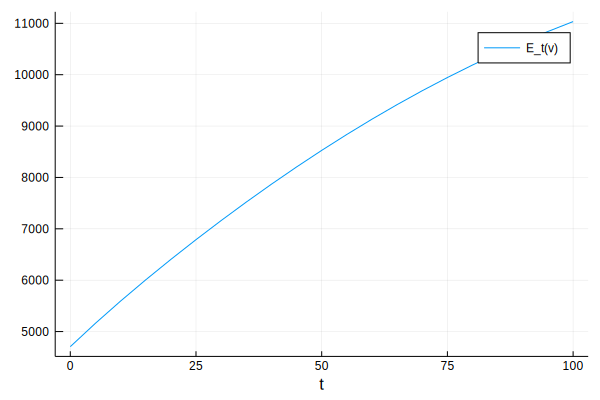

In [66]:
using OrdinaryDiffEq, DiffEqOperators

function solve_transition_dynamics(p, t)
    @unpack N, M = p

    ψ_0 = [1.0; fill(0.0, N^M - 1)]
    O! = MatrixFreeOperator((dψ, ψ, p, t) -> Q_T_mul!(dψ, ψ, p), (p, 0.0), size=(N^M,N^M), opnorm=(p)->1.25)

    # definindo o problema correspondente do ODE
    prob = ODEProblem(O!,ψ_0,(0.0,t[end]), p)
    return solve(prob, LinearExponential(krylov=:simple), tstops = t)
end
t = 0.0:5.0:100.0
p = default_params(N=10, M=6)
sol = solve_transition_dynamics(p, t)
v = solve_bellman(p)
plot(t, [dot(sol(tval), v) for tval in t], xlabel = "t", label = ["E_t(v)"])

O gráfico acima (1) calcula a dinâmica completa da cadeia de Markov a partir de $ n_m = 1 $ para todas as condições iniciais de $ m $; (2) resolve a dinâmica de um sistema de um milhão de EDOs; e; (3) usa o cálculo da equação de Bellman para encontrar a avaliação esperada durante essa transição. Todo o processo leva menos de 30 segundos.